In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

In [2]:
dataPathLocal = "G:/My Drive/keras_project/dataDigits"

In [3]:
batch_size = 32
num_classes = 53

img_height = 64
img_width = 64


In [4]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataPathLocal,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
     batch_size=batch_size
)

Found 25757 files belonging to 53 classes.
Using 20606 files for training.
Using 5151 files for validation.


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,837 (2.12 MB)

 Trainable params: 554,837 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9906 - loss: 0.0327 - val_accuracy: 0.9517 - val_loss: 0.2156
Epoch 2/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9893 - loss: 0.0387 - val_accuracy: 0.9979 - val_loss: 0.0076
Epoch 3/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9924 - loss: 0.0232 - val_accuracy: 0.9926 - val_loss: 0.0290
Epoch 4/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9921 - loss: 0.0278 - val_accuracy: 0.9938 - val_loss: 0.0189
Epoch 5/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9923 - loss: 0.0257 - val_accuracy: 0.9946 - val_loss: 0.0182
Epoch 6/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.9938 - loss: 0.0202 - val_accuracy: 0.9897 - val_loss: 0.0315
Epoch 7/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9919 - loss: 0.0274 - val_accuracy: 0.9870 - val_loss: 0.0482
Epoch 8/50
644/644 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9939 - loss: 0.0193 - 

In [53]:
card_names = "kaiserin,koenig,koenigin,kriegsherr,prinzessin,elbenschuetzen,leichte_kavallerie,ritter,waldlaeufer,zwergeninfanterie,buch_der_veraenderung,juwel_der_ordnung,rune_des_schutzes,schild_von_keth,weltenbaum,basilisk,drache,einhorn,hydra,schlachtross,blitz,buschfeuer,feuerwesen,kerze,schmiede,grosse_flut,insel,quelle_des_lebens,sumpf,wasserwesen,erdwesen,gebirge,glockenturm,hoehle,wald,elbischer_bogen,kampfzeppelin,kriegsschiff,schwert_von_keth,zauberstab,blizzard,luftwesen,rauch,regensturm,wirbelsturm,hexenmeister,sammler,herr_der_bestien,totenbeschwoerer,magierin,doppelgaenger,gestaltenwandler,spiegelung"
card_names_sep = card_names.split(",")
card_names_sep.sort()

In [69]:
path = "C:/Users/Test/Desktop/zauberstab.jpg"

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
pos = np.argmax(score)
prediction = card_names_sep[pos]


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(prediction, 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to hydra with a 100.00 percent confidence.


In [57]:
model.save("C:/Users/Test/Desktop/WiSe24/nn/project/model/model_small_50.keras")

In [ ]:
model = keras.models.load_model("C:/Users/Test/Desktop/WiSe24/nn/project/model/realms.keras")

In [59]:
import tensorflow as tf

model = tf.keras.models.load_model("C:/Users/Test/Desktop/WiSe24/nn/project/model/model_small_50.keras")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_small_50.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Test\AppData\Local\Temp\tmprouipjvo\assets


INFO:tensorflow:Assets written to: C:\Users\Test\AppData\Local\Temp\tmprouipjvo\assets


Saved artifact at 'C:\Users\Test\AppData\Local\Temp\tmprouipjvo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 53), dtype=tf.float32, name=None)
Captures:
  1663290470672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736451344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736447120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736436944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736447696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736446736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736451728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661736450960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661739994384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1661739998800: TensorSpec(shape=(), dtype=tf.resource, name=None)


C:\Users\Test\anaconda3\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


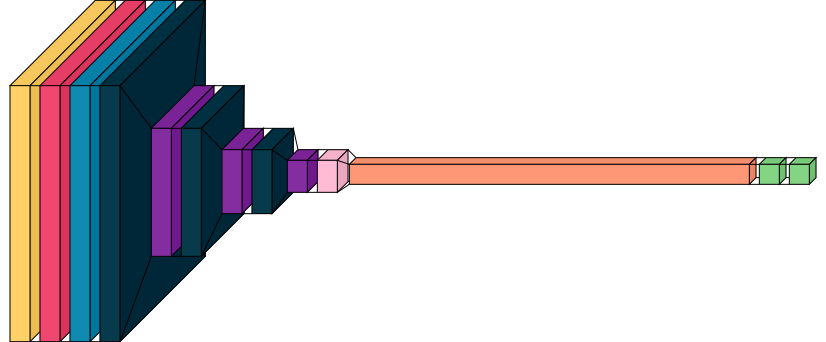

In [73]:
import visualkeras
visualkeras.layered_view(model)

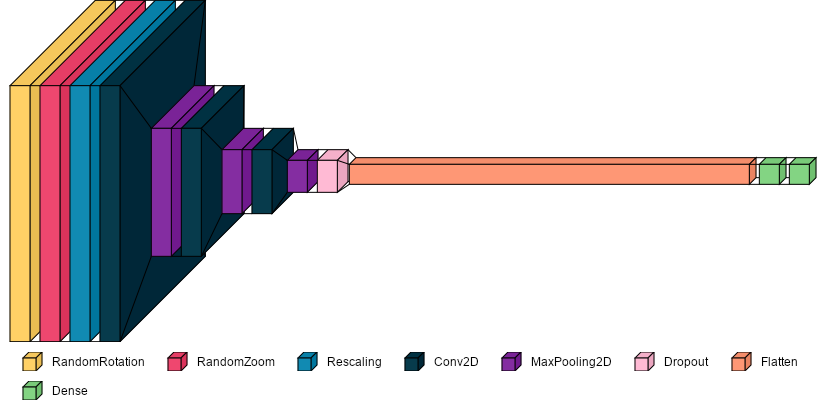

In [75]:
visualkeras.layered_view(model, legend=True) # without custom font
from PIL import ImageFont
font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font) # selected font